In [2]:
%load_ext autoreload
%autoreload 2
main_dir = r'../../..'
data_path = main_dir+'/data'
import sys
sys.path.append(main_dir)
from typing import List, Set, Dict, Optional, Any, Tuple, Type, Union

from BayDS.lib.pipeline import *
from BayDS.lib.io import *

import os


In [20]:
working_folder=f'{main_dir}/Snapshots/1/Training2509_Vfeat'

In [4]:
data_dir = f'{main_dir}/Snapshots/1/Training2509'
v_dir = f'{main_dir}/Snapshots/1/VFeatures'
p = Pipeline(working_folder=f'{main_dir}/Snapshots/1/Training2509_Vfeat')

p.add_node(LoaderNode, None, 'data',
           params={
               'input_directory': data_dir,
               'file': 'data.pkl'
           })
p.add_node(LoaderNode, None, 'numerical_columns',
           params={
               'input_directory': data_dir,
               'file': 'numerical_columns.yaml'
           })
p.add_node(LoaderNode, None, 'categorical_columns',
           params={
               'input_directory': data_dir,
               'file': 'categorical_columns.yaml'
           })
p.add_node(LoaderNode, None, 'v_features',
           params={
               'input_directory': v_dir,
               'file': 'v_features_reduced.pkl'
           })
p.add_node(LoaderNode, None, 'v_features',
           params={
               'input_directory': v_dir,
               'file': 'v_features_reduced.pkl'
           })
p.add_node(JoinNode,
           ('data', 'v_features'),
           'data',
           params={
               'on': 'TransactionID'
           })
p.add_node(EraserNode,
           params={
    'remove_keys': ['v_features']
})
p.save()
p.run()

VFeatures_to_remove = [f'V{i}' for i in range(1,340)]
VFeatures_to_remove = [vf for vf in VFeatures_to_remove if vf in p.data['data'].columns]
p.add_node(EraserNode,
           params={
    'remove_keys': ['v_features']
})
p.save()

p.add_node(DropFeaturesNode,
           ('data','numerical_columns','categorical_columns'),
           ('data','numerical_columns','categorical_columns'),
           params={
               'drop': VFeatures_to_remove,
           })
p.save()
p.run(verbose=True)

p.data['numerical_columns'].extend([col for col in p.data['data'].columns if col.startswith('V_PCA')])
p.save_data()

---------------------------
0: LoaderNode [2019-09-28 12:54:00]
params:
 {'input_directory': '../../../Snapshots/1/Training2509', 'file': 'data.pkl'}
---------------------------
1: LoaderNode [2019-09-28 12:54:02]
params:
 {'input_directory': '../../../Snapshots/1/Training2509', 'file': 'numerical_columns.yaml'}
---------------------------
2: LoaderNode [2019-09-28 12:54:02]
params:
 {'input_directory': '../../../Snapshots/1/Training2509', 'file': 'categorical_columns.yaml'}
---------------------------
3: LoaderNode [2019-09-28 12:54:02]
params:
 {'input_directory': '../../../Snapshots/1/VFeatures', 'file': 'v_features_reduced.pkl'}
---------------------------
4: LoaderNode [2019-09-28 12:54:04]
params:
 {'input_directory': '../../../Snapshots/1/VFeatures', 'file': 'v_features_reduced.pkl'}
---------------------------
5: JoinNode [2019-09-28 12:54:05]
params:
 {'on': 'TransactionID'}
---------------------------
6: EraserNode [2019-09-28 12:54:46]
params:
 {'remove_keys': ['v_features']

In [12]:
p.add_node(DownsamplingTrainNode, 'data', 'train_data',
          params={
               'strategy':'reduction_factor',
               'reduction_factor': 0.2,
           })
p.save()
p.run(verbose=True)

---------------------------
8: DownsamplingTrainNode [2019-09-28 13:01:14]
params:
 {'strategy': 'reduction_factor', 'reduction_factor': 0.2}


## Code to make pipeline node

In [13]:
# df = p.data['data']
train = p.data['train_data'][p.data['train_data'].isFraud >= 0]
test =  p.data['data'][p.data['data'].isFraud < 0]


In [14]:
X = train.drop('isFraud',axis=1)
y = train['isFraud']

test =  test.drop('isFraud',axis=1)

X.replace(np.inf, np.nan, inplace=True)
X.replace(-np.inf, np.nan, inplace=True)
test.replace(np.inf, np.nan, inplace=True)
test.replace(-np.inf, np.nan, inplace=True)

categorical_features = [c for c, col in enumerate(X.columns) if col in p.data['categorical_columns']]

del p
train_idx = train.index
del train
gc.collect()

0

In [15]:
for col in X.columns:
    if str(X[col].dtype) == 'datetime64[ns]':
        print (col, X[col].dtype)
        X[col] = pd.to_timedelta(X[col]).map(lambda qq:qq.days)
        test[col] = pd.to_timedelta(test[col]).map(lambda qq:qq.days)
#         X[col] = X[col].astype(datetime.datetime)

start_date datetime64[ns]


c:\python37\lib\site-packages\pandas\util\_decorators.py:208: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  return func(*args, **kwargs)


In [16]:
from sklearn.model_selection import KFold
n_fold = 5
# folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=5)

In [17]:
from BayDS.lib.training import *

Using TensorFlow backend.
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as

In [18]:
test

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,V_PCA_7300_2,V_PCA_7300_3,V_PCA_7300_4,V_PCA_7300_5,V_PCA_7300_6,V_PCA_938449_0,V_PCA_938449_1,V_PCA_938449_2,V_PCA_938449_3,V_PCA_938449_4
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663549,31.950000762939453,0,835,1,0,0,0,0,39,0,...,0.289877096546962,-0.091256422005949,-0.048587506672797,-0.327969201196197,0.268264935518528,-0.21751675032623,-0.029469075241344,-0.011814284460428,0.065417129464098,0.00576887808051
3663550,49.000000000000000,0,90,1,0,0,0,0,1,0,...,0.289877096546962,-0.091256422005949,-0.048587506672797,-0.327969201196197,0.268264935518528,-0.21751675032623,-0.029469075241344,-0.011814284460428,0.065417129464098,0.00576887808051
3663551,171.000000000000000,0,1372,491,0,0,0,0,20,0,...,0.435701383846913,0.482920556506507,0.071794738036895,-0.310699981388025,0.209688942982483,-0.21751675032623,-0.029469075241344,-0.011814284460428,0.065417129464098,0.00576887808051
3663552,284.950012207031250,0,97,9,0,0,2,0,26,0,...,1.156214447308747,-0.572542517636750,-0.405083322746114,-0.443071511941646,-1.069088333420431,-0.21751675032623,-0.029469075241344,-0.011814284460428,0.065417129464098,0.00576887808051
3663553,67.949996948242188,0,65,53,0,1,4,0,4,0,...,-0.220960831206074,0.205546821712036,-1.297690083700719,-0.369940819878188,-0.321228011155513,-0.21751675032623,-0.029469075241344,-0.011814284460428,0.065417129464098,0.00576887808051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4170235,94.679000854492188,1,39,20,1,1,1,0,49,2,...,-0.179606723596003,-0.107766062387079,0.304612144255083,0.281329416125136,-0.141240009573960,-0.21751675032623,-0.029469075241344,-0.011814284460428,0.065417129464098,0.00576887808051
4170236,12.173000335693359,1,12,13,1,1,1,0,0,1,...,-2.792772457110790,0.919287913055914,-2.266050544534329,-1.643547985875535,-0.577320356638508,-0.21751675032623,-0.029469075241344,-0.011814284460428,0.065417129464098,0.00576887808051
4170237,49.000000000000000,0,147,3,0,0,0,0,18,0,...,-0.179606723596003,-0.107766062387079,0.304612144255083,0.281329416125136,-0.141240009573960,-0.21751675032623,-0.029469075241344,-0.011814284460428,0.065417129464098,0.00576887808051


Fold 1 started at Sat Sep 28 13:02:32 2019
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.961645	training's auc: 0.961645	valid_1's auc: 0.881704	valid_1's auc: 0.881704
[200]	training's auc: 0.976394	training's auc: 0.976394	valid_1's auc: 0.8901	valid_1's auc: 0.8901
[300]	training's auc: 0.987196	training's auc: 0.987196	valid_1's auc: 0.896746	valid_1's auc: 0.896746
[400]	training's auc: 0.993658	training's auc: 0.993658	valid_1's auc: 0.901686	valid_1's auc: 0.901686
[500]	training's auc: 0.997089	training's auc: 0.997089	valid_1's auc: 0.90582	valid_1's auc: 0.90582
[600]	training's auc: 0.998771	training's auc: 0.998771	valid_1's auc: 0.907848	valid_1's auc: 0.907848
[700]	training's auc: 0.999509	training's auc: 0.999509	valid_1's auc: 0.909152	valid_1's auc: 0.909152
[800]	training's auc: 0.999814	training's auc: 0.999814	valid_1's auc: 0.910069	valid_1's auc: 0.910069
[900]	training's auc: 0.999935	training's auc: 0.999935	valid_1's au

[900]	training's auc: 0.999953	training's auc: 0.999953	valid_1's auc: 0.929863	valid_1's auc: 0.929863
[1000]	training's auc: 0.999988	training's auc: 0.999988	valid_1's auc: 0.930259	valid_1's auc: 0.930259
[1100]	training's auc: 0.999998	training's auc: 0.999998	valid_1's auc: 0.93063	valid_1's auc: 0.93063
[1200]	training's auc: 1	training's auc: 1	valid_1's auc: 0.930913	valid_1's auc: 0.930913
[1300]	training's auc: 1	training's auc: 1	valid_1's auc: 0.931091	valid_1's auc: 0.931091
[1400]	training's auc: 1	training's auc: 1	valid_1's auc: 0.931213	valid_1's auc: 0.931213
[1500]	training's auc: 1	training's auc: 1	valid_1's auc: 0.931404	valid_1's auc: 0.931404
Early stopping, best iteration is:
[1389]	training's auc: 1	training's auc: 1	valid_1's auc: 0.931181	valid_1's auc: 0.931181
CV mean score: 0.9355, std: 0.0142.


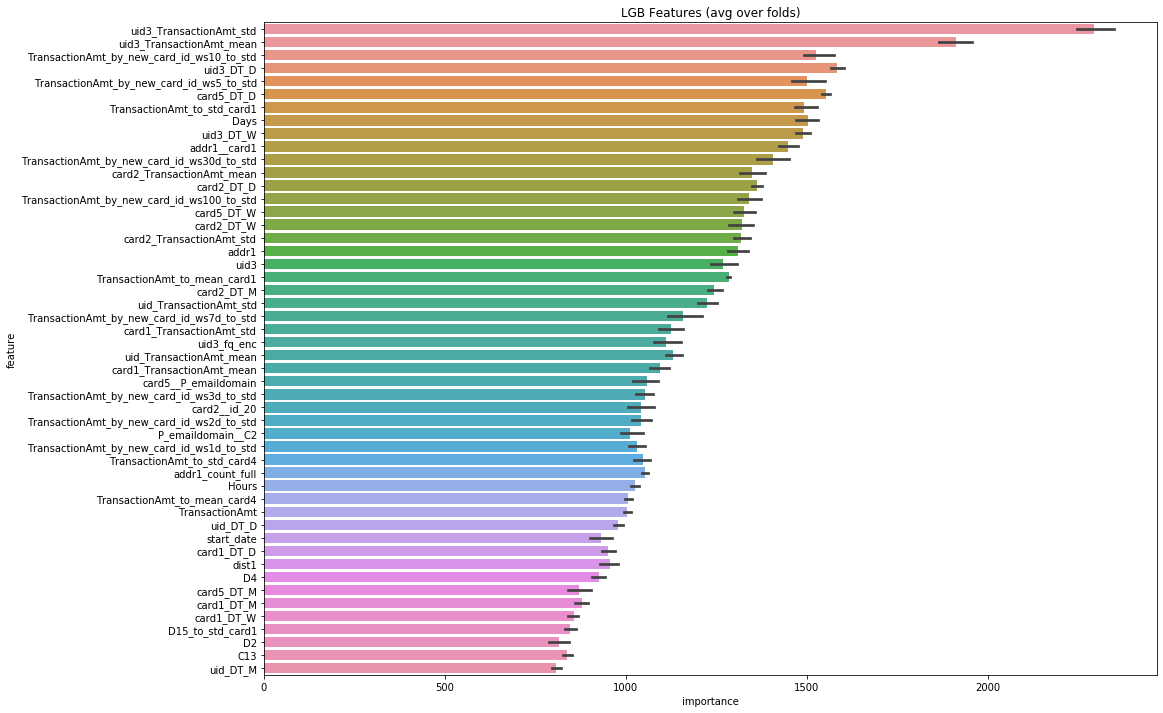

In [19]:
gc.collect()
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
         }
result_dict_lgb = train_model_classification(X=X, X_test=test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=100, early_stopping_rounds=200, n_estimators=10000, averaging='usual', n_jobs=-1, groups=None)

In [21]:
pd.DataFrame(result_dict_lgb['oof'], columns=['isFraud'], index=train_idx).to_csv(f'{working_folder}/oof.csv')

pd.DataFrame(result_dict_lgb['prediction'], columns=['isFraud'], index=test.index).to_csv(f'{working_folder}/prediction.csv')

sample_submission = pd.read_csv(data_path + '/sample_submission.csv').set_index('TransactionID')

sub1 = pd.DataFrame(result_dict_lgb['prediction'], columns=['isFraud'], index=test.index)

sample_submission['isFraud'] = sub1#*0.5 + sub2*0.25 + sub3*0.25

sample_submission.to_csv(f'{working_folder}/lgb_sub.csv')

In [26]:
cv = np.array(result_dict_lgb['scores'])
coef = np.array([ 0.02316714,  0.11418089,  0.45246619, -0.43529977,  0.86800837])
pred_cv = sum(cv*coef)
print(pred_cv)

0.9458047905780911
